In [89]:
def modelCircle(b, c, d):
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return cx,cy,radius

def shrtDis(p,x,y,r):
    import numpy as np
    re= np.array(abs(((p[:,0]-x)**2+(p[:,1]-y)**2)**0.5-r))
    return re

In [90]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b =-1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )








#result = np.where(PO<1)


0.44513635788538997 45
0.434767942588939 48
0.4041710287307083 41
0.40367377868306875 51
0.3999219911663274 48
0.3947881107028796 45
0.37992138536289777 46
0 0


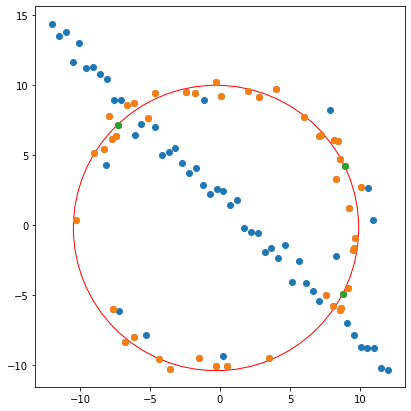

In [94]:
best=np.Infinity
v,m,R,ranL=0,0,0,[]

for i in range(400):
    #L=np.random.random_integers(0,99,size=3)
    L=np.random.choice(100, size=3, replace=False)
    
  
    x,y,r=modelCircle(X[L[0]],X[L[1]],X[L[2]])
    PO=shrtDis(X,x,y,r)
    if r>20:
        continue
    inliares=X[PO<1]
    if inliares.size>80:
        
        me=shrtDis(inliares,x,y,r)
        mean = sum(me/me.size)
        if mean < best:
            print(mean,me.size)
            best=mean
            ranL=L
            

x,y,r=modelCircle(X[ranL[0]],X[ranL[1]],X[ranL[2]])
PO=shrtDis(X,x,y,r)
bestInlier=X[PO<1]
fig,ax=plt.subplots(figsize=(7,7))

c=plt.Circle((x,y),r,fill=False)
c.set_color("r")
ax.set_aspect( 1 )
ax.add_artist( c )
ax.scatter(X[:,0],X[:,1])
ax.scatter(bestInlier[:,0],bestInlier[:,1])
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
ax.scatter(Y[:,0],Y[:,1])
print(v,m)



In [95]:
def ransac(Data,N,t,n):
    best=np.Infinity
    output=[]

    for i in range(N):
        rndPoints=np.random.choice(Data.size//2, size=3, replace=False)
        x,y,r=modelCircle(Data[rndPoints[0]],Data[rndPoints[1]],Data[rndPoints[2]])
        PO=shrtDis(Data,x,y,r)
        if r>max(Data[:,1])*1.5:
            continue
        inliares=Data[PO<t]
        if inliares.size/2>n:
            
            me=shrtDis(inliares,x,y,r)
            mean = sum(me/me.size)
            if mean < best:
               
                best=mean
                output=rndPoints
                inli=inliares
   
    return output,inli
def plotCiircle(Data,Datalst,color='r'):
    x,y,r=modelCircle(Datalst[Data[0]],Datalst[Data[1]],Datalst[Data[2]])
    c=plt.Circle((x,y),r,fill=False)
    c.set_color(color)
    return c


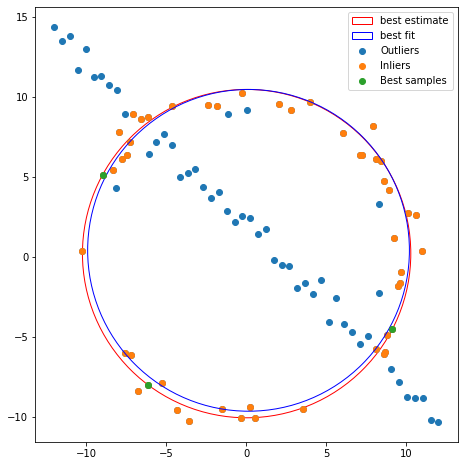

In [97]:
ranL,bestInlier=ransac(X,50,1,40)          
c=plotCiircle(ranL,X)
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( c )
p1=ax.scatter(X[:,0],X[:,1])
p2=ax.scatter(bestInlier[:,0],bestInlier[:,1])
bestfit,inl=ransac(bestInlier,50,1,bestInlier.size//2.2)
c2=plotCiircle(bestfit,bestInlier,'b')
ax.add_artist( c2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
p3=ax.scatter(Y[:,0],Y[:,1])
plt.legend(handles=[c, c2,p1,p2,p3],labels=['best estimate','best fit','Outliers','Inliers','Best samples'])
plt.show()

In [212]:
def ransac2(Data,N,t,n):
    maxi=0
    output=np.array([])

    for i in range(N):
        rndPoints=np.random.choice(Data.size//2, size=3, replace=False)
        x,y,r=modelCircle(Data[rndPoints[0]],Data[rndPoints[1]],Data[rndPoints[2]])
        PO=shrtDis(Data,x,y,r)
        if r>max(Data[:,1])*1.5:
            continue
        inliares=Data[PO<t]
        if len(inliares)>n:
            
            
            
               
            me=shrtDis(inliares,x,y,r)
            mean = sum(me/me.size)
            if maxi < len(inliares):
               
                best=mean
                output=rndPoints
                inli=inliares
            elif maxi== len(inliares) and best>mean:
                best=mean
                output=rndPoints
                inli=inliares

                
    return output,inli

    

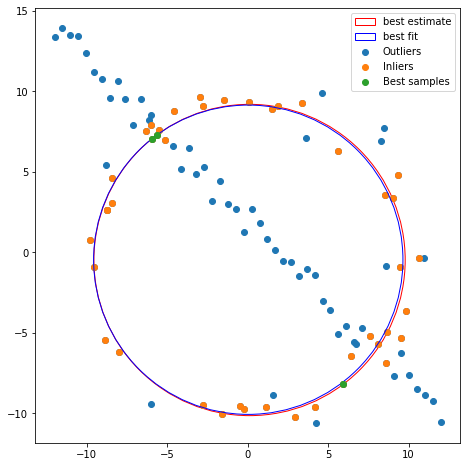

In [219]:
ranL,bestInlier=ransac2(X,500,1,40)          
c=plotCiircle(ranL,X)
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( c )
p1=ax.scatter(X[:,0],X[:,1])
p2=ax.scatter(bestInlier[:,0],bestInlier[:,1])
bestfit,inl=ransac2(bestInlier,50,1,bestInlier.size//2.2)
c2=plotCiircle(bestfit,bestInlier,'b')
ax.add_artist( c2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
p3=ax.scatter(Y[:,0],Y[:,1])
plt.legend(handles=[c, c2,p1,p2,p3],labels=['best estimate','best fit','Outliers','Inliers','Best samples'])
plt.show()

In [5]:
import numpy as np
np.linalg.eig(np.array([[3,1,-1],[2,2,-1],[2,2,0]]))

(array([2.00000005, 1.99999995, 1.        ]),
 array([[-4.08248297e-01,  4.08248284e-01,  4.47213595e-01],
        [-4.08248297e-01,  4.08248284e-01, -2.10650008e-16],
        [-8.16496575e-01,  8.16496587e-01,  8.94427191e-01]]))

(640, 800, 3)


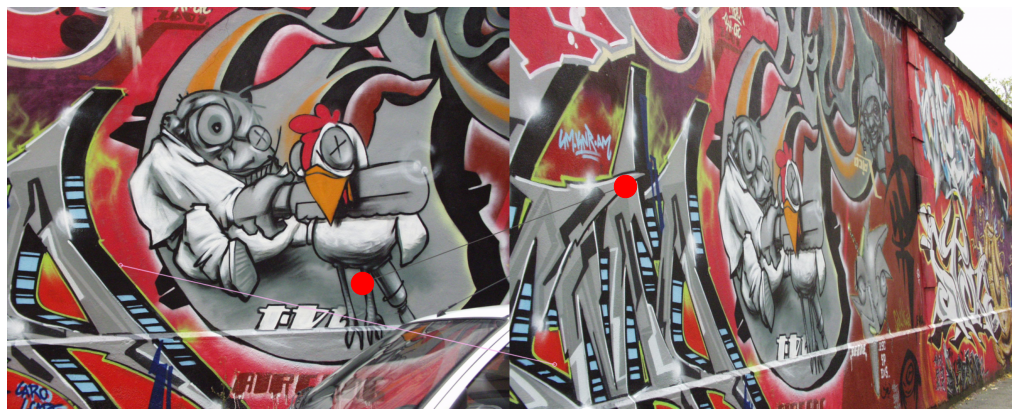

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread(r"graf\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"graf\img5.ppm", cv.IMREAD_COLOR)
print(img2.shape)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:2], None, flags =2)
fig, ax = plt.subplots(1,1, figsize = (18, 18))
plt.imshow(img3)
plt.scatter(keypoints_1[matches[1].queryIdx].pt[0], keypoints_1[matches[1].queryIdx].pt[1], s=500, c='red', marker='o')
plt.scatter(keypoints_2[matches[1].trainIdx].pt[0]+800, keypoints_2[matches[1].trainIdx].pt[1], s=500, c='red', marker='o')
plt.axis('off')
plt.show()


In [82]:
print(keypoints_1[matches[1].queryIdx].pt[0], keypoints_1[matches[1].queryIdx].pt[1])

xs1,ys1=keypoints_1[matches[0].queryIdx].pt
xs2,ys2=keypoints_1[matches[1].queryIdx].pt
xs3,ys3=keypoints_1[matches[2].queryIdx].pt
xs4,ys4=keypoints_1[matches[3].queryIdx].pt

xd1,yd1=keypoints_2[matches[0].trainIdx].pt
xd2,yd2=keypoints_2[matches[1].trainIdx].pt
xd3,yd3=keypoints_2[matches[2].trainIdx].pt
xd4,yd4=keypoints_2[matches[3].trainIdx].pt

A=np.array([[xs1,ys1,1,0,0,0,-xd1*xs1,-xd1*ys1,-xd1],[
    0,0,0,xs1,ys1,1,-yd1*xs1,-yd1*ys1,-yd1],
    [xs2,ys2,1,0,0,0,-xd2*xs2,-xd2*ys2,-xd2],
    [0,0,0,xs2,ys2,1,-yd2*xs2,-yd2*ys2,-yd2],
    [xs3,ys3,1,0,0,0,-xd3*xs3,-xd3*ys3,-xd3],
    [0,0,0,xs3,ys3,1,-yd3*xs3,-yd3*ys3,-yd3],
    [xs4,ys4,1,0,0,0,-xd4*xs4,-xd4*ys4,-xd4],
    [0,0,0,xs4,ys4,1,-yd4*xs4,-yd4*ys4,-yd4]]
    )

np.linalg.eig((A.T)@A)
[ 1.47539897e-03,  9.39521708e-04, -2.83470666e-01,
         -7.22061528e-01,  1.82530203e-01, -1.92381912e-01,
         -5.72633058e-01,  5.47717149e-03,  1.33390069e-03]

564.5857543945312 439.66961669921875


(array([4.48135216e+11, 2.04263182e+10, 1.91293703e+06, 1.41968661e+05,
        4.16659939e+04, 4.80818720e+04, 1.48123982e+03, 1.92968378e-02,
        8.80771299e-10]),
 array([[ 5.68793594e-04,  1.07110920e-03,  7.36588941e-01,
          3.86204354e-02,  6.28159165e-01, -2.00240987e-01,
         -1.45812649e-01,  1.40422690e-03,  1.83709777e-04],
        [ 3.92357697e-04,  2.94310782e-04,  5.81018342e-01,
         -5.42743419e-01, -5.67105547e-01,  1.27504048e-01,
          1.73113958e-01, -3.54592422e-03,  1.64071838e-04],
        [ 9.66154853e-07,  1.25719312e-06,  1.30363437e-03,
         -6.18027559e-04, -1.65214094e-03, -5.99590156e-05,
          8.67749729e-03,  9.86294215e-01, -1.64753225e-01],
        [ 1.47539897e-03,  9.39521708e-04, -2.83470666e-01,
         -7.22061528e-01,  1.82530203e-01, -1.92381912e-01,
         -5.72633058e-01,  5.47717149e-03,  1.33390069e-03],
        [ 1.18058359e-03, -1.41961466e-03, -1.98155238e-01,
         -4.04310107e-01,  3.86713657e-01, -1.

((-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 799.5, -0.5))

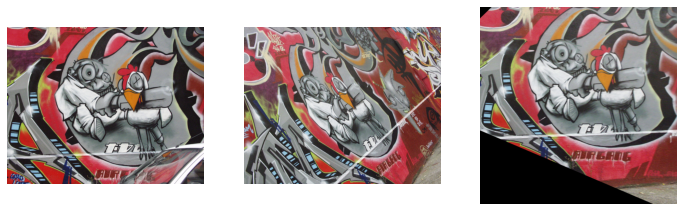

In [83]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im1 = cv.imread(r"./graf/img1.ppm",cv.IMREAD_ANYCOLOR)
im4 = cv.imread(r"./graf/img4.ppm",cv.IMREAD_ANYCOLOR)
im1=cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im4=cv.cvtColor(im4,cv.COLOR_BGR2RGB)

H=np.array([[6.6378505e-01,   6.8003334e-01,  -3.1230335e+01],[-1.4495500e-01 ,  9.7128304e-01  , 1.4877420e+02],[4.2518504e-04 , -1.3930359e-05  , 1.0000000e+00]])


imlto4 = cv.warpPerspective(im4,np.linalg.inv(H),(800,800))

fig,ax =plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(im1)
ax[1].imshow(im4)
ax[2].imshow(imlto4)
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')


((-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 799.5, -0.5))

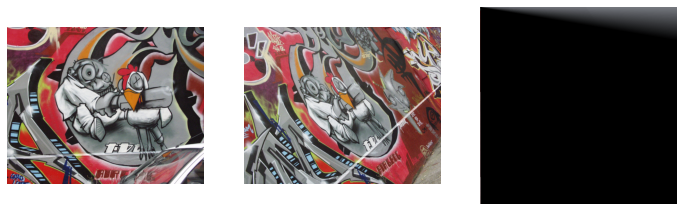

In [86]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im1 = cv.imread(r"./graf/img1.ppm",cv.IMREAD_ANYCOLOR)
im4 = cv.imread(r"./graf/img4.ppm",cv.IMREAD_ANYCOLOR)
im1=cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im4=cv.cvtColor(im4,cv.COLOR_BGR2RGB)

H=np.array([[ 5.68793594e-04,  1.07110920e-03,  7.36588941e-01],
          [3.86204354e-02,  6.28159165e-01, -2.00240987e-01],
         [-1.45812649e-01,  1.40422690e-03,  1.83709777e-04]])

H=H*4.48135216e+11
imlto4 = cv.warpPerspective(im4,np.linalg.inv(H),(800,800))

fig,ax =plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(im1)
ax[1].imshow(im4)
ax[2].imshow(imlto4)
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')
